# ARIMA Modelling 

Start Date: 5/6/2024

End Date:


**Steps:**

1. Load data
2. Plot data
3. Check stationary:
> - Transform to stationary using differencing, decide for parameter d
> - Plot ACF and PACF to decide for parameter p and q
4. Data is split into Train-Test-Set (interchangeable with either step 3 or 5)
5. Using auto-arima and function to get p,d,&q parameter and then, fit model
6. Prediction on test set
7. Evaluate using metrics and plotting
8. Future dates prediction reading


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## 1. Read the data

In [2]:
df2=pd.read_csv('data/household_power_consumption_cleaned_datetime_index_drop_intensity.csv')
df2.head()

,DateTime,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2007-01-01 00:00:00,2.580,0.136,241.97,0.0,0.0,0.0
1,2007-01-01 00:01:00,2.552,0.100,241.75,0.0,0.0,0.0
2,2007-01-01 00:02:00,2.550,0.100,241.64,0.0,0.0,0.0
3,2007-01-01 00:03:00,2.550,0.100,241.71,0.0,0.0,0.0
4,2007-01-01 00:04:00,2.554,0.100,241.98,0.0,0.0,0.0


In [3]:
# Set the datetime column as the index
#df2.set_index('DateTime', inplace=True)
df2.set_index(pd.to_datetime(df2['DateTime']), inplace=True)
# Drop the date column from our data.
df2.drop(columns='DateTime', inplace=True)
df2.head()

,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,0.0,0.0,0.0
2007-01-01 00:01:00,2.552,0.100,241.75,0.0,0.0,0.0
2007-01-01 00:02:00,2.550,0.100,241.64,0.0,0.0,0.0
2007-01-01 00:03:00,2.550,0.100,241.71,0.0,0.0,0.0
2007-01-01 00:04:00,2.554,0.100,241.98,0.0,0.0,0.0


In [4]:
# Ensure the index is a DatetimeIndex
#df2.index = pd.to_datetime(df2.index)

In [5]:
df = df2[['Global_active_power']].copy()
df.head()
#The copy() method is used to ensure that the new DataFrame is independent of the original DataFrame 
#and any changes made to it won't affect the original DataFrame.

,Global_active_power
DateTime,
2007-01-01 00:00:00,2.580
2007-01-01 00:01:00,2.552
2007-01-01 00:02:00,2.550
2007-01-01 00:03:00,2.550
2007-01-01 00:04:00,2.554


In [6]:
df.tail()

,Global_active_power
DateTime,
2007-06-30 23:55:00,2.880
2007-06-30 23:56:00,2.892
2007-06-30 23:57:00,2.882
2007-06-30 23:58:00,2.660
2007-06-30 23:59:00,2.548


In [7]:
df.dtypes

Global_active_power    float64
dtype: object

In [8]:
# Convert DataFrame to CSV
df.to_csv('ts_dataset.csv', index=True)

In [9]:
if df['Global_active_power'].isnull().any():
    print("There are NaN values in the 'Global_active_power' column.")
else:
    print("There are no NaN values in the 'Global_active_power' column.")

There are no NaN values in the 'Global_active_power' column.


**A) The dataset will be resampled to weekly frequency**

Aggregating to Lower Frequency: 
  
- If your original data is at a high frequency (e.g., daily or hourly), aggregate it to a lower frequency (e.g., weekly or monthly) by computing summary statistics (e.g., sum, mean) over each interval. This reduces the number of data points while preserving the overall trends and patterns in the data.

In [11]:
#df.index = pd.to_datetime(df.index)

#resample the dataset
agg_df = df.resample('W').sum()  # Aggregate data to weekly frequency by summing values
agg_df.head()

,Global_active_power
DateTime,
2007-01-07,10587.220937
2007-01-14,6195.794937
2007-01-21,16525.666000
2007-01-28,15295.744937
2007-02-04,11467.652000


### Starting here our the dataframe use for modelling is : `agg_df`

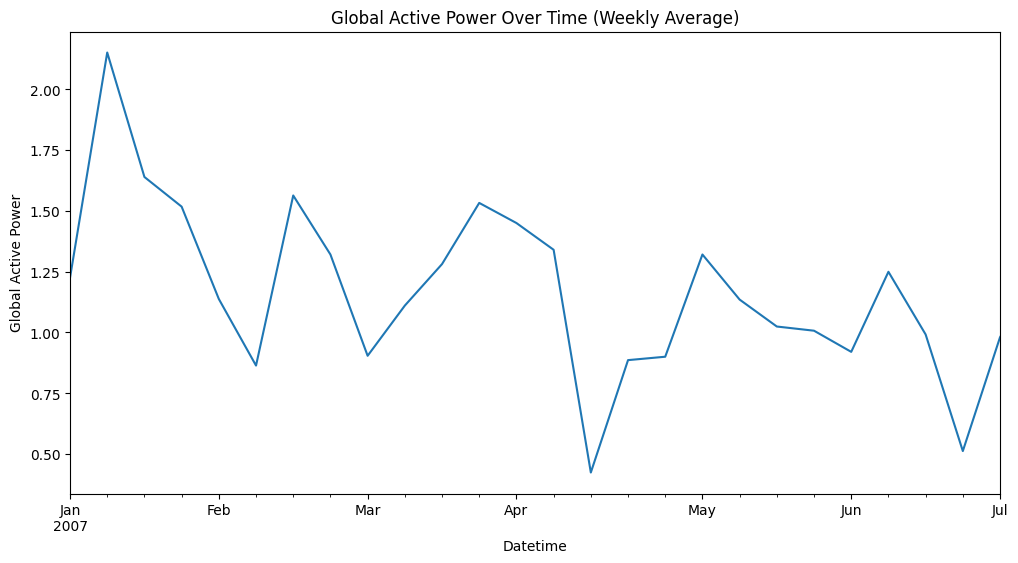

In [10]:
df.index = pd.to_datetime(df.index)
# Resample the data to daily frequency and calculate the mean
df_resampled = df['Global_active_power'].resample('W').mean()

# Plot the resampled data
plt.figure(figsize=(12, 6))
df_resampled.plot(kind='line')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power')
plt.title('Global Active Power Over Time (Weekly Average)')

# Set the x-axis limits to display dates until 30/06/2007
plt.xlim(df_resampled.index.min(), pd.Timestamp('2007-06-30'))

plt.show()

## 2. Plot the data to check for variance and trend

i) Plotting original dataframe without resampling

(13514.0, 13694.0)

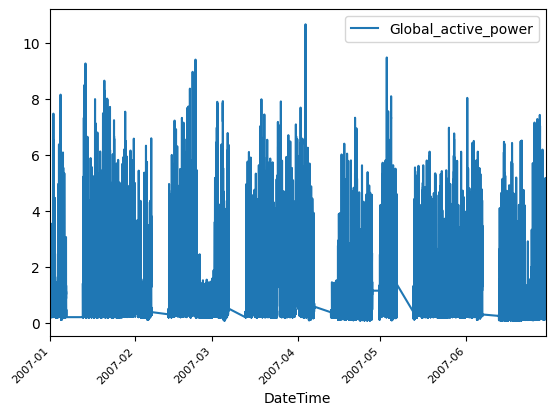

In [12]:
# Plot the data
df.plot()
plt.xticks(rotation=45, fontsize=8, ha='right')  # for easy readability
# Set the x-axis limits to display dates until 30/06/2007
plt.xlim(df.index.min(), '2007-06-30')
# Show the plot
#plt.show()

ii) Plotting resampled dataframe 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 2007-01-07 to 2007-12-09
Freq: W-SUN
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Global_active_power  49 non-null     float64
dtypes: float64(1)
memory usage: 784.0 bytes


(1932.0, 1957.0)

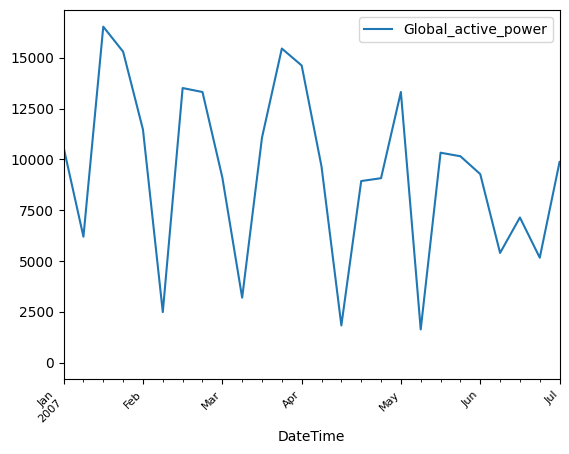

In [13]:
agg_df.info()

agg_df.plot()
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.xlim(df.index.min(), '2007-06-30')#for easy readability
#plt.xticks(45)

iii) Plotting to see the seasonal patternof time series

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

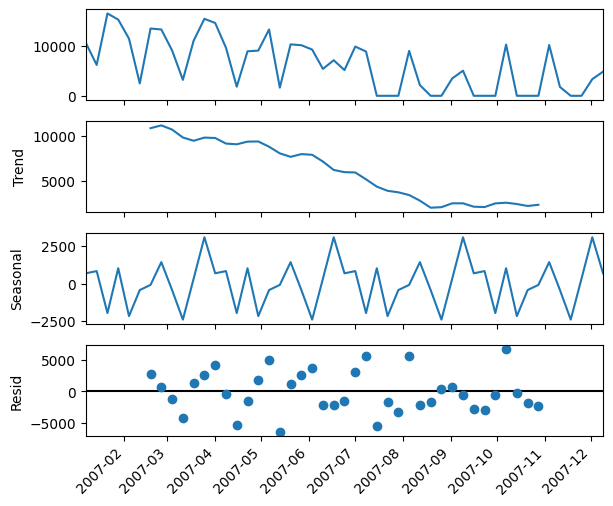

In [15]:
model = seasonal_decompose(agg_df,model='additive',period=12)  #this is how it will look when we lessen the time records,more neat

fig = model.plot()

# Rotate the x-axis labels
for ax in fig.axes:  # Iterate through the axes in the figure
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')

plt.show()
#https://blog.devops.dev/lets-talk-about-your-first-arima-model-cbfdcba1749e

# 3. Check for stationarity of time series

**i) Check the stationarity**

**Methods to check on stationarity of the time series**
1. Method 1: time series plot
2. Method 2: ACF plot and PACF plot
3. Method 3: ADF test (Augmented Dickey-Fuller test)
    
- Transform
- Cross-check

**Method 1: time series plot**

if there is upper and downward trend , it is not stationary

**Method 2: ACF plot and PACF plot**

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

- As our dataframe is **agg_df**

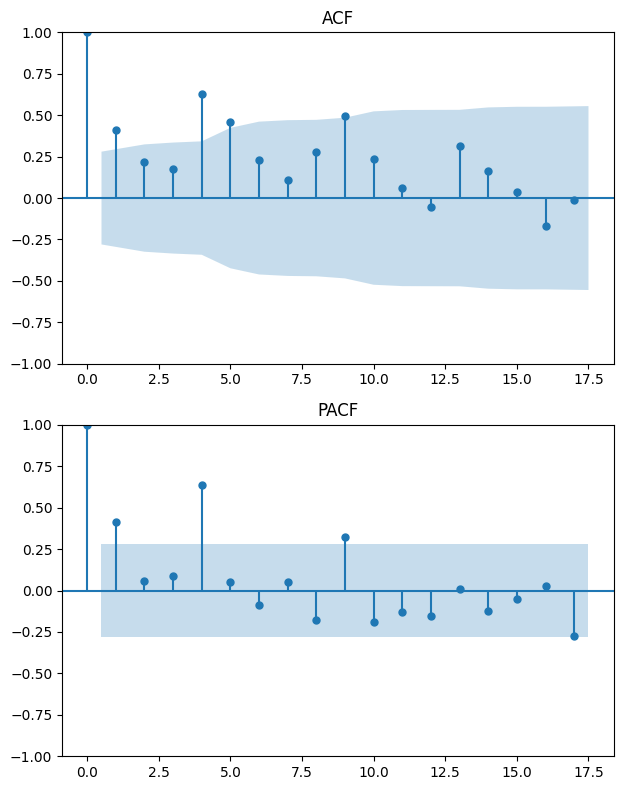

In [17]:
#active_series = df['Global_active_power']

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Plot ACF
plot_acf(agg_df, ax=ax[0, 0])
ax[0, 0].set_title('ACF')

# Plot PACF
plot_pacf(agg_df, ax=ax[1, 0])
ax[1, 0].set_title('PACF')

# Remove empty subplot
fig.delaxes(ax[0, 1])
fig.delaxes(ax[1, 1])

plt.tight_layout()
plt.show()

<details>
  <summary>Why my ACF and PACF blue dense area is so small</summary>
  
  If the blue dense part of your ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots appears small, it could be due to a few reasons:

1. **Sample Size**: If your dataset is small, the number of lags considered for the ACF and PACF plots may be limited. This can result in a smaller blue region, indicating fewer available lags for correlation analysis.

2. **Lag Selection**: The size of the blue region depends on the number of lags considered for the plots. If you have a large dataset but are only plotting a small number of lags, the blue region may appear small.

3. **Correlation Magnitude**: The height of the bars in the ACF and PACF plots represents the magnitude of correlation. If the correlations are weak overall, the bars may be short, leading to a smaller blue region.

4. **Statistical Significance**: The blue region represents the confidence interval for the correlations. If the correlations are not statistically significant, the blue region may be narrow, indicating less certainty about the correlation values.

To address this issue:

- **Increase Sample Size**: If possible, collect more data to increase the sample size and provide more information for the ACF and PACF analysis.

- **Adjust Lag Selection**: Increase the number of lags considered for the plots to include more data points and potentially expand the blue region.

- **Evaluate Correlation Magnitude**: Assess the magnitude of correlations in your data. If correlations are weak, consider whether your data truly exhibits autocorrelation patterns.

- **Consider Statistical Significance**: Ensure that the correlations observed in your data are statistically significant. Narrow blue regions may indicate that correlations are not significant.

By considering these factors, you can better interpret the ACF and PACF plots and understand the autocorrelation patterns in your data. If you're still unsure about the interpretation, it may be helpful to consult with a statistician or data analyst for further guidance.
</details>

From **ACF** and **PACF** plot, we see our data is (both for original and train which is original too no?)
- ACF has decay plot gradually
- while PACF has significant spike 
- this show our model is ARIMA(p,d,0)

#okay have to check back

ACF nampak turun kat 3?

**Method 3: ADF test (Augmented Dickey-Fuller test)**

In [18]:
from statsmodels.tsa.stattools import adfuller
#adf_test = adfuller(df_train)
#print(f'p-value: {adf_test[1]}')
#this is for one-dimensional array
#The error you're seeing with the adfuller function is due to the same issue: it expects a one-dimensional array, 
#but you are providing a two-dimensional DataFrame. 
#You need to pass a specific column of your DataFrame to the function

In [19]:
adf_test_1 = adfuller(agg_df)

# Print the p-value
print(f'p-value: {adf_test_1[1]}')

p-value: 0.8355024422577104


In [20]:
##creating a function for values 
def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", round(dftest[1],6))
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
       print("\t",key, ": ", val)
    if dftest[0] < dftest[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

adf_test(agg_df['Global_active_power']) 

1. ADF :  -0.742242149063168
2. P-Value :  0.835502
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 40
5. Critical Values :
	 1% :  -3.6055648906249997
	 5% :  -2.937069375
	 10% :  -2.606985625
Failed to Reject Ho - Time Series is Non-Stationary


<details>
  <summary>What the p-value tell us is: (click to expand)</summary>
  
A p-value of 0.0 (or very close to zero) from the Augmented Dickey-Fuller (ADF) test, indicates that the null hypothesis of the test (which states that the series has a unit root and is non-stationary) can be rejected with high confidence. **Therefore, a p-value of 0.0 suggests that data is indeed stationary.**

Here's a more detailed explanation:
    
Null Hypothesis (H0): The time series has a unit root (i.e., it is non-stationary).
    
Alternative Hypothesis (H1): The time series does not have a unit root (i.e., it is stationary).
    
When the p-value is very low (typically below a threshold such as 0.05), reject the null hypothesis.
    
</details>


**ii) Transform the time-series to stationary**

- Transform time-series to stationary by differencing

<Axes: xlabel='DateTime'>

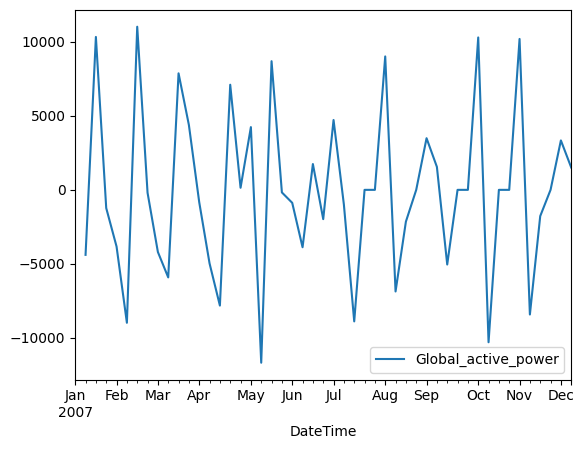

In [21]:
agg_df.diff().plot()
#agg_df.diff().dropna() #if u want to drop the first row with NaN
#df_diff.plot()

In [22]:
df_diff = agg_df.diff().dropna()
#remove first row
#if not cannot run adfuller

**iii) Cross-check after transform**

Check the p-value after differencing, if p-value is still high, make a differencing on the diff_series,and repeat ADF test

In [23]:
adf_test_2 = adfuller(df_diff)

# Print the p-value
print(f'p-value: {adf_test_2[1]}')  #slicing to extract only second value for that adfuller method

p-value: 0.0005752940973862704


In [24]:
#Now lets check the p-value after differencing
##creating a function for values 
def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", round(dftest[1],6))
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
       print("\t",key, ": ", val)
    if dftest[0] < dftest[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

adf_test(df_diff['Global_active_power']) 

#from https://blog.devops.dev/lets-talk-about-your-first-arima-model-cbfdcba1749e

1. ADF :  -4.234673605099009
2. P-Value :  0.000575
3. Num Of Lags :  7
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 40
5. Critical Values :
	 1% :  -3.6055648906249997
	 5% :  -2.937069375
	 10% :  -2.606985625
Reject Ho - Time Series is Stationary


### Starting from here our dataframe is `df_diff`

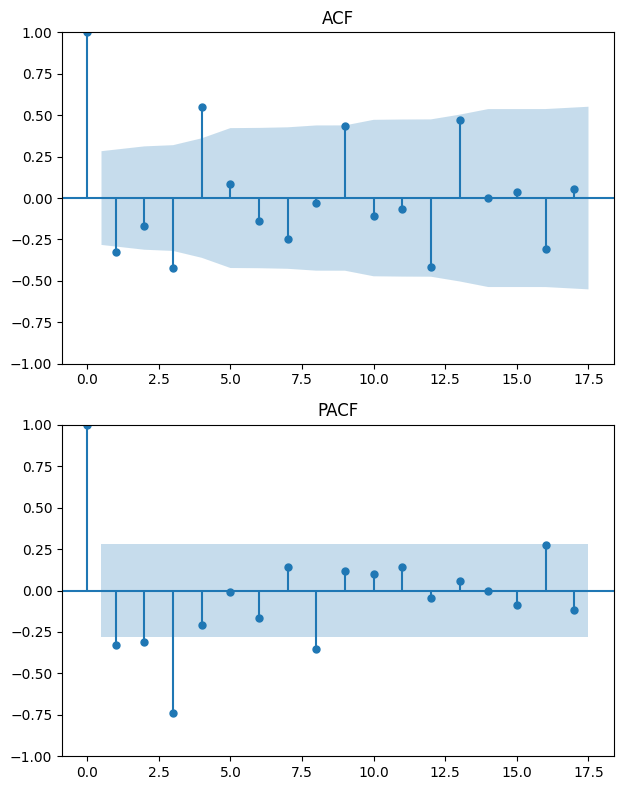

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Plot ACF
plot_acf(df_diff, ax=ax[0, 0])
ax[0, 0].set_title('ACF')

# Plot PACF
plot_pacf(df_diff, ax=ax[1, 0])
ax[1, 0].set_title('PACF')

# Remove empty subplot
fig.delaxes(ax[0, 1])
fig.delaxes(ax[1, 1])

plt.tight_layout()
plt.show()
#if use df_diff that does not remove first row, the acf pacf will be weird, only one tail

as we differencing once to achieve the p-value smaller than 0.05 as to make our dataset is stationary, our parameter for **d = 1**

## 4. Split Data to Train-Test-Split

In [26]:
df_diff.head()
#no NaN

,Global_active_power
DateTime,
2007-01-14,-4391.426000
2007-01-21,10329.871063
2007-01-28,-1229.921063
2007-02-04,-3828.092937
2007-02-11,-8979.804000


In [27]:
#len(df_diff) #48
#12 test
train=df_diff[:36]
test=df_diff[36:]

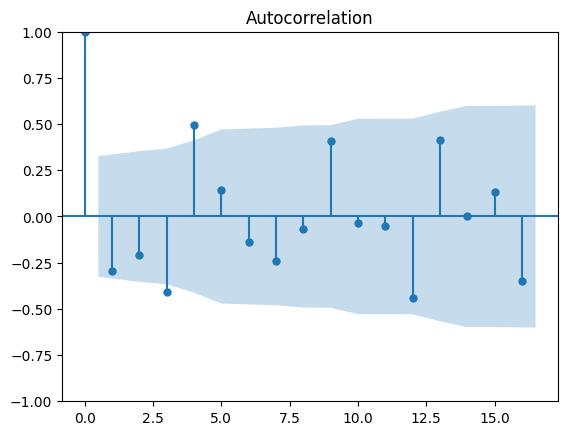

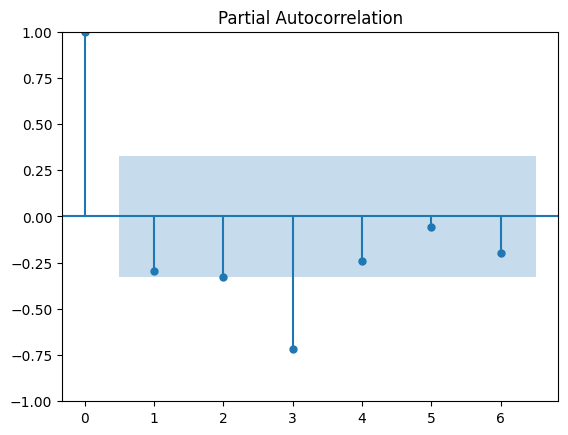

In [30]:
#y_train=pd.Series(y_train)
acf_train = plot_acf(train)
pacf_train = plot_pacf(train, lags=6)

# 5. Choosing parameter using auto_arima

<details>
  <summary>Here's how to determine p and q:</summary>
  
Identify p (AR component):

Check ACF plot for significant drop in autocorrelation values or first crossing of confidence interval.
Lag before drop indicates p.

Identify q (MA component):

Check PACF plot for significant drop in partial autocorrelation values or first crossing of confidence interval.
Lag before drop indicates q.

evaluate the model's performance using techniques such as AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion) to select the best model.
</details>




**Methods**

1. Using auto_arima to get pdq combination with lowest AIC

2. Using function to get pdqcombinations with the lowest RMSE

In [134]:
import pmdarima as pm
from pmdarima import auto_arima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

### i. Based on AIC: The best p,d,q(4, 1, 7)

In [160]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(8):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting ARIMA({p}, 1, {q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(train, order=(p, 1, q))
            
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting ARIMA(0, 1, 0)
The AIC for ARIMA(0,1,0) is: 739.613418397584
Attempting ARIMA(0, 1, 1)
The AIC for ARIMA(0,1,1) is: 711.4231350875402
Attempting ARIMA(0, 1, 2)
The AIC for ARIMA(0,1,2) is: 695.8931759337552
Attempting ARIMA(0, 1, 3)
The AIC for ARIMA(0,1,3) is: 697.5478723747641
Attempting ARIMA(0, 1, 4)
The AIC for ARIMA(0,1,4) is: 697.3433292282299
Attempting ARIMA(0, 1, 5)
The AIC for ARIMA(0,1,5) is: 688.0482491788712
Attempting ARIMA(0, 1, 6)
The AIC for ARIMA(0,1,6) is: 691.8084693868691
Attempting ARIMA(0, 1, 7)
The AIC for ARIMA(0,1,7) is: 692.6272679711154
Attempting ARIMA(1, 1, 0)
The AIC for ARIMA(1,1,0) is: 729.9648038835412
Attempting ARIMA(1, 1, 1)
The AIC for ARIMA(1,1,1) is: 710.4742520399736
Attempting ARIMA(1, 1, 2)
The AIC for ARIMA(1,1,2) is: 712.9507092438961
Attempting ARIMA(1, 1, 3)
The AIC for ARIMA(1,1,3) is: 698.8185968533612
Attempting ARIMA(1, 1, 4)
The AIC for ARIMA(1,1,4) is: 697.3886106655109
Attempting ARIMA(1, 1, 5)
The AIC for ARIMA(1,1,5) i

### ii. Based on RMSE: The best p,d,q(6, 1, 6)

In [42]:
import itertools

In [126]:
# Define the ranges for p, d, q
p = range(0, 8)  # p ranges from 0 to 7 (not including 8)
d = 1            # d is fixed at 1
q = range(0, 8)  # q ranges from 0 to 7 (not including 8)

# Generate all combinations of p, d, q
pdq_combination = list(itertools.product(p, [d], q))

# Print the length of pdq_combination
print("Total combinations:", len(pdq_combination))

# Initialize lists to store results
rmse = []
mae = []
mape = []
order1 = []

# Loop through each combination of p, d, q
for pdq in pdq_combination:
    try:
        # Fit the ARIMA model on the training data
        model = ARIMA(train, order=pdq).fit()

        # Predict the values for the test set
        pred = model.predict(start=len(train), end=(len(train) + len(test) - 1))

        # Calculate error metrics
        error_rmse = np.sqrt(mean_squared_error(test, pred))
        error_mae = mean_absolute_error(test, pred)
        error_mape = np.mean(np.abs((test - pred) / test)) * 100

        # Append results to lists
        order1.append(pdq)
        rmse.append(error_rmse)
        mae.append(error_mae)
        mape.append(error_mape)
    except Exception as e:
        print(f"An error occurred for order {pdq}: {e}")
        continue

# Create a DataFrame to store the results
results = pd.DataFrame({
    'Order': order1,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
})

print(results)

# Find the row with the minimum RMSE
min_rmse_row = results.loc[results['RMSE'].idxmin()]
lowest_rmse_value = results['RMSE'].min()

print("Best parameters with lowest RMSE:")
print(min_rmse_row)
print("Lowest RMSE value:", lowest_rmse_value)

Total combinations: 64
        Order         RMSE          MAE  MAPE
0   (0, 1, 0)  7945.194719  6885.563895   NaN
1   (0, 1, 1)  5824.822345  3962.151515   NaN
2   (0, 1, 2)  5861.555782  4082.389052   NaN
3   (0, 1, 3)  5861.987690  4084.112849   NaN
4   (0, 1, 4)  5811.363919  4031.783969   NaN
..        ...          ...          ...   ...
59  (7, 1, 3)  5020.340571  3840.830440   NaN
60  (7, 1, 4)  4774.580938  4013.734166   NaN
61  (7, 1, 5)  5781.872698  4957.772779   NaN
62  (7, 1, 6)  4255.270326  3497.005875   NaN
63  (7, 1, 7)  5797.855131  3818.965500   NaN

[64 rows x 4 columns]
Best parameters with lowest RMSE:
Order      (6, 1, 6)
RMSE     2972.236785
MAE      2527.591738
MAPE             NaN
Name: 54, dtype: object
Lowest RMSE value: 2972.236784990938


### We will proceed with ARIMA (6, 1, 6) for the model

# 5. Fit the ARIMA model to data

**1. Model 1 :ARIMA(6, 1, 6)**

In [161]:
#model Training for Model 1
arima = ARIMA(train, order=(6,1,6)) ## p,d,q
model = arima.fit()

In [162]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                   36
Model:                  ARIMA(6, 1, 6)   Log Likelihood                -330.779
Date:                 Sun, 23 Jun 2024   AIC                            687.558
Time:                         23:24:57   BIC                            707.777
Sample:                     01-14-2007   HQIC                           694.537
                          - 09-16-2007                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.1650      0.169    -12.791      0.000      -2.497      -1.833
ar.L2         -2.9898      0.376     -7.942      0.000      -3.728      -2.252
ar.L3         -3.4295      0.429     -7.988      0.000      -4.271      -2.588
ar.L4         -2.7262      0.425     -6.409      0.000      -3.560      -1.892
ar.L5         -1.7060      0.340     -5.024      0.000      -2.372      -1.040
ar.L6         -0.7695      0.134     -5.741      0.000      -1.032      -0.507
ma.L1          0.6741     30.096      0.022      0.982     -58.313      59.662
ma.L2         -0.3330     35.037     -0.010      0.992     -69.004      68.338
ma.L3         -0.6898     21.055     -0.033      0.974     -41.956      40.577
ma.L4         -1.0113      6.873     -0.147      0.883     -14.483      12.460
ma.L5         -0.2341     17.902     -0.013      0.990     -35.321      34.852
ma.L6          0.5945      0.464      1.280      0.200      -0.316       1.505
sigma2      4.998e+06   2.43e-05   2.06e+11      0.000       5e+06       5e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.72
Prob(Q):                              0.99   Prob(JB):                         0.42
Heteroskedasticity (H):               0.96   Skew:                             0.32
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.35e+30. Standard errors may be unstable.
"""

# 6. Make predictions on Test Set

**Model: ARIMA(6, 1, 6)**

In [163]:
# Generate predictions based on test set.
preds = model.predict(start=test.index[0], end = test.index[-1])
#preds = model.predict(start=len(train), end=(len(df_diff)-1))

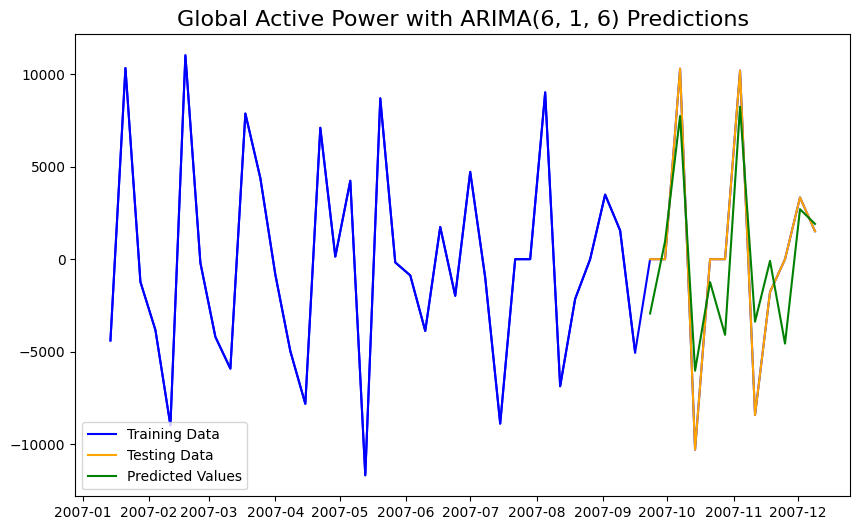

In [165]:
combined_series = pd.concat([train, test])

plt.figure(figsize=(10, 6))

# Plot combined data
plt.plot(combined_series.index, combined_series, color='blue')

# Highlight the training data portion
plt.plot(train.index, train, color='blue', label='Training Data')

# Highlight the testing data portion
plt.plot(test.index, test, color='orange', label='Testing Data')

# Optionally plot the predicted test values
# if 'preds' is defined and has the same index as 'y_test'
plt.plot(test.index, preds, color='green', label='Predicted Values')

plt.title('Global Active Power with ARIMA(6, 1, 6) Predictions', fontsize=16)
plt.legend()
plt.show()

## 7. Evaluate the model

**Model: ARIMA(6, 1, 6)**

In [166]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(test, preds)
mape = mean_absolute_percentage_error(test, preds)
rmse = np.sqrt(mean_squared_error(test, preds))

print(f'mae - Model 1: {mae}')
print(f'mape - Model 1: {mape}')
print(f'rmse - Model 1: {rmse}')

mae - Model 1: 2527.5917384168292
mape - Model 1: 5.176224904310406e+18
rmse - Model 1: 2972.236784990938


Evaluation of Current Model

Given the current model, here are some steps to evaluate its performance and suitability:

Compare with Baselines: Evaluate model against simple baselines like the naive forecast, simple moving average, and mean forecast.

Check Residuals: Analyze the residuals (errors) of model to check for patterns. If there are patterns, model may be missing key aspects of the data (e.g., seasonality).( i found one in the tutorial,maybe need to revisit)

Cross-Validation: Use time-series cross-validation methods to ensure model generalizes well to unseen data.

### Overall view

For the model, as we overlay, we can see the trend for prediction and forecast for the next 2 years compare to the original `global active reading`

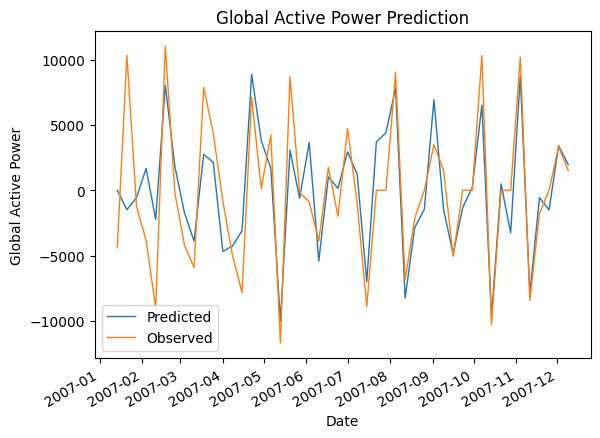

In [169]:
act_power_df = df_diff['Global_active_power']
#df_filtered = df.set_index(pd.to_datetime(df.index)).sort_index().loc[:'2007-08'] 
# Group by the datetime index and calculate the mean of 'Global_active_power'
df_resampled = act_power_df.resample('W').mean()  # Resampling to daily frequency and calculating mean


model = ARIMA(df_resampled, order=(6,1,6))  # Initializing ARIMA model
fitted_model = model.fit()  # Fitting the model to the resampled data
predictions = fitted_model.predict()  # Making predictions

plt.plot(predictions, linewidth=1)  # Plotting predicted values
df_resampled.plot(linewidth=1) 
#df_resampled.rolling(5).mean().plot(linewidth=1)  # Plotting observed values with a rolling mean
plt.legend(['Predicted', 'Observed'])
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.title('Global Active Power Prediction')
plt.show()

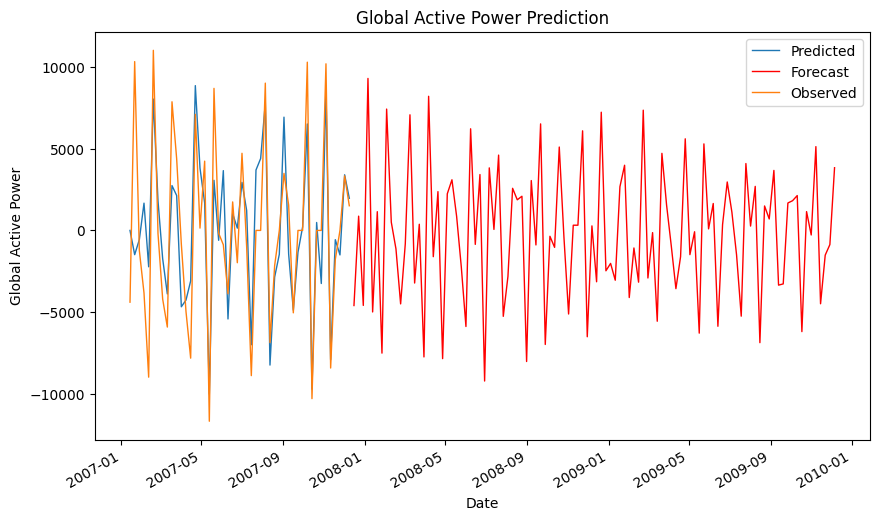

In [172]:
act_power_df = df_diff['Global_active_power']

# Resampling to weekly frequency and calculating mean
df_resampled = act_power_df.resample('W').mean()

# Initializing ARIMA model with order=(6, 1, 6)
model = ARIMA(df_resampled, order=(6, 1, 6))

# Fitting the model to the resampled data
fitted_model = model.fit()

# Number of periods to forecast (2 years = 104 weeks)
forecast_periods = 104

# Making predictions for the next 2 years
predictions = fitted_model.get_forecast(steps=forecast_periods).predicted_mean

# Extend index for the future dates
index_future_dates = pd.date_range(start=df_resampled.index[-1], periods=forecast_periods + 1, freq='W')[1:]

# Assigning the index to the predictions
predictions.index = index_future_dates

# Plotting observed and predicted values
plt.figure(figsize=(10, 6))
predictions_overlay = fitted_model.predict()  # Making predictions
plt.plot(predictions_overlay, linewidth=1)
plt.plot(predictions, linewidth=1, color='red')  # Plotting predicted values
df_resampled.plot(linewidth=1)  # Plotting observed values
plt.legend(['Predicted','Forecast', 'Observed'])
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.title('Global Active Power Prediction')
plt.show()

## 8. For future readings

In [39]:
from statsmodels.tsa.arima.model import ARIMA

C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


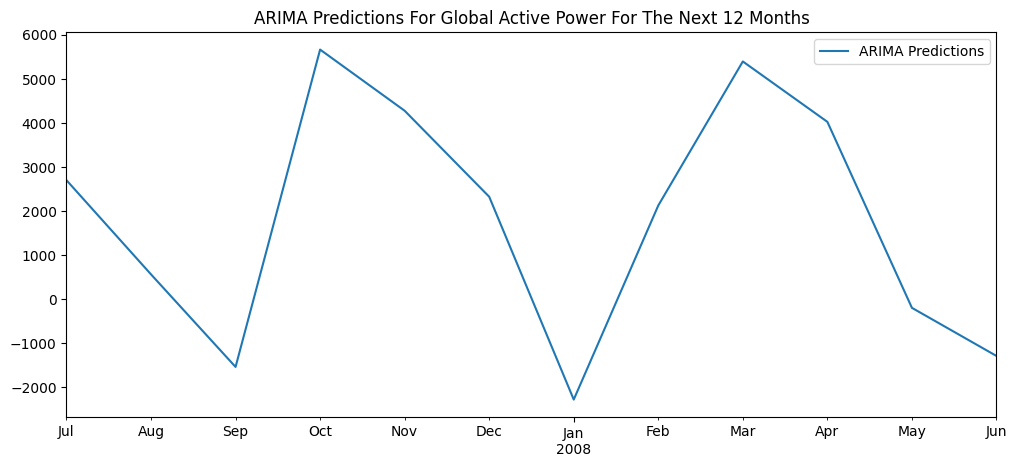

In [40]:
# Fitting the entire data
model = ARIMA(agg_df['Global_active_power'], order=(6,1,6))  # Create model instance
fitted_model = model.fit()  # Fit the model

# Generating index for future dates (next 12 months)
index_future_dates = pd.date_range(start='2007-07-01', end='2008-06-01', freq='MS')

# Predicting for the next 12 months
pred = fitted_model.predict(start=len(agg_df), end=len(agg_df) + 11, typ='levels').rename('ARIMA Predictions')
pred = round(pred, 2)

# Assigning the index to the predictions
pred.index = index_future_dates

# Plotting prediction
plt.figure(figsize=(12, 5))
pred.plot(legend=True)

plt.title('ARIMA Predictions For Global Active Power For The Next 12 Months')
plt.show()

In [41]:
# Generating index for future dates (next 12 months)
index_future_dates = pd.date_range(start='2007-07-01', end='2008-06-01', freq='MS')

# Predicting for the next 12 months
pred = fitted_model.predict(start=len(agg_df), end=len(agg_df) + 11, typ='levels').rename('ARIMA Predictions')
pred = round(pred, 2)

# Assigning the index to the predictions
pred.index = index_future_dates[:len(pred)]  # Adjusting the length of the index

# Print the predictions
print(pred)


2007-07-01    2695.80
2007-08-01     556.24
2007-09-01   -1546.37
2007-10-01    5662.95
2007-11-01    4273.60
2007-12-01    2319.80
2008-01-01   -2287.97
2008-02-01    2121.36
2008-03-01    5392.99
2008-04-01    4021.07
2008-05-01    -203.96
2008-06-01   -1296.89
Freq: MS, Name: ARIMA Predictions, dtype: float64


C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


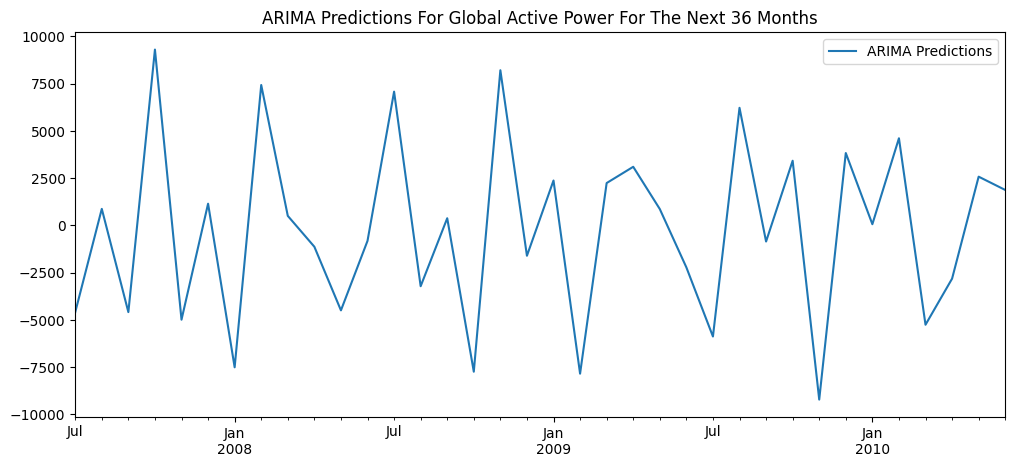

In [178]:
# Suppress all warnings
warnings.filterwarnings("ignore")
# Fitting the entire data
model = ARIMA(df_diff['Global_active_power'], order=(6,1,6))  # Create model instance
fitted_model = model.fit()  # Fit the model

# Generating index for future dates (next 12 months)
index_future_dates = pd.date_range(start='2007-07-01', periods=36, freq='MS')

# Predicting for the next 12 months
pred = fitted_model.predict(start=len(df_diff), end=len(df_diff) + 35, typ='levels').rename('ARIMA Predictions')
pred = round(pred, 2)

# Assigning the index to the predictions
pred.index = index_future_dates

# Plotting prediction
plt.figure(figsize=(12, 5))
pred.plot(legend=True)
#df_diff['Global_active_power'].resample('M').mean().plot(linewidth=1)
plt.title('ARIMA Predictions For Global Active Power For The Next 36 Months')
plt.show()

In [179]:
# Generating index for future dates (next 3 years, 36 months)
index_future_dates = pd.date_range(start='2007-07-01', periods=36, freq='MS')

# Predicting for the next 3 years (36 months)
pred = fitted_model.predict(start=len(df_diff), end=len(df_diff) + 35, typ='levels').rename('ARIMA Predictions')
pred = round(pred, 2)

# Assigning the index to the predictions
pred.index = index_future_dates  # Use the new index for 3 years

# Print the predictions
print(pred)

2007-07-01   -4596.14
2007-08-01     872.61
2007-09-01   -4589.97
2007-10-01    9300.27
2007-11-01   -4990.02
2007-12-01    1146.19
2008-01-01   -7509.18
2008-02-01    7425.33
2008-03-01     502.03
2008-04-01   -1131.63
2008-05-01   -4496.65
2008-06-01    -820.68
2008-07-01    7074.32
2008-08-01   -3219.96
2008-09-01     376.79
2008-10-01   -7742.19
2008-11-01    8207.47
2008-12-01   -1607.99
2009-01-01    2373.20
2009-02-01   -7845.88
2009-03-01    2238.84
2009-04-01    3098.68
2009-05-01     863.91
2009-06-01   -2221.91
2009-07-01   -5880.09
2009-08-01    6218.93
2009-09-01    -854.71
2009-10-01    3419.60
2009-11-01   -9217.02
2009-12-01    3826.75
2010-01-01      60.88
2010-02-01    4608.44
2010-03-01   -5258.01
2010-04-01   -2819.34
2010-05-01    2576.62
2010-06-01    1873.52
Freq: MS, Name: ARIMA Predictions, dtype: float64


As the above modelling in for **Part 3:**

- I did achieve fitting the model with ARIMA, make prediction and future readings, but as :
>- the error is high
>- the overlay does not look nice, so

**For Part 4**

I plan to 
1. I want tp produce prediction reading for global active power
2. I want to lessen the RMSE through new pdq combination by using function
3. I will try several ways to get the best model by either log, new pdq,new model
4. I want to see how prediction line overlay to my observed train and test line for my new model with new pdq


Plan for next **part 5**
- change the train-test-split using notebook ref used in class
- find pdq parameter based AIC instead of RMSE
- try SARIMAX model
- tuning SARIMAX model
- produce future reading using SARIMAX

For **part 4**
- I did achieve the goal to produce prediction reading for global active power
- I did lessen the RMSE through new pdq combination by using function
- I try several ways to get the best model
- I try new model (SARIMAX)
- I can see how prediction line overlay to my observed train and test line

my github repo: https://github.com/kabedkaca/CSP_DA24C3

## As the overlay between prediction and observed using ARIMA RMSE is 2972.24, maybe the other forecast model can predict better.

### Next notebook will present the SARIMAX modelling